# Brain Tumor Classification using Convolutional Neural Network

## Project Topic
A brain tumor refers to a mass or collection of abnormal cells in the brain that grow and multiply uncontrollably. Brain tumors can be classified as primary or secondary/malignant, depending on whether they originate in the brain or spread to the brain from other parts of the body. There are several types of brain tumors, and one common type is glioma, which originates from the glial cells that surround and support neurons. 

Early detection and classification of brain tumors help in selecting the most convenient treatment method to save patient's life. However, brain Tumors are complex and a professional neurosurgeon is required for MRI analysis. This process is prone to human errors and often times in developing countries the lack of skillful doctors makes it really challenging and time-consuming to generate reports from MRI. 

Application of automated detection and classification techniques using Deep Learning (DL) has consistently shown higher accuracy than manual classification. The **aim** of this project is to perform the detection and classification of brain tumors by using Deep Learning with Convolution-Neural Network (CNN), an artificial neural network widely used for image recognition and classification. The method would be helpful for doctors to make the accurate and fast diagnoses. 

## Import the required libraries

In [1]:
%matplotlib inline
import numpy as np
import os
import pandas as pd
import cv2
from tqdm import tqdm
import io
import matplotlib.pyplot as plt
plt.rc('axes', titlesize=18)     
plt.rc('axes', labelsize=14)   
plt.rc('xtick', labelsize=12)    
plt.rc('ytick', labelsize=12)    
plt.rc('legend', fontsize=12)    
plt.rc('font', size=13) 
import seaborn as sns
from sklearn.utils import shuffle 
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras.layers import Input, BatchNormalization
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.models import Sequential

from sklearn.metrics import classification_report, confusion_matrix
import scikitplot as skplt
import warnings 
warnings.filterwarnings('ignore')

## Dataset

The dataset that we will be using for this work is a combination of the following three datasets:
- [Figshare](https://figshare.com/articles/dataset/brain_tumor_dataset/1512427)
- [Brain Tumor Classification Dataset](https://www.kaggle.com/datasets/sartajbhuvaji/brain-tumor-classification-mri)
- [Br35H](https://www.kaggle.com/datasets/ahmedhamada0/brain-tumor-detection?select=no)

More information about this dataset can be found [here](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset). 

### Load the data

In [2]:
labels = ['glioma', 'meningioma', 'notumor', 'pituitary']

X_train = [] 
Y_train = [] 

image_size=128

for i in labels:
    folderPath = os.path.join('../input/brain-tumor-mri-dataset', 'Training', i)
    for j in tqdm(os.listdir(folderPath)):
        image = cv2.imread(os.path.join(folderPath, j))
        image = cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        Y_train.append(i)       
        
for i in labels:
    folderPath = os.path.join('../input/brain-tumor-mri-dataset', 'Testing', i) 
    for j in tqdm(os.listdir(folderPath)):
        image = cv2.imread(os.path.join(folderPath, j))
        image = cv2.resize(image, (image_size, image_size))
        X_train.append(image)
        Y_train.append(i)
        
#  image and label have been appended as list, now they are converted into array
X_train = np.array(X_train)
Y_train = np.array(Y_train)

100%|██████████| 300/300 [00:01<00:00, 276.72it/s]


In [3]:
# Shuffling data
X_train, Y_train = shuffle(X_train, Y_train, random_state=42)

X_train.shape

(7023, 128, 128, 3)

In [4]:
Y_train

array(['notumor', 'meningioma', 'notumor', ..., 'pituitary', 'pituitary',
       'glioma'], dtype='<U10')

The whole dataset contains **7023** images of human brain MRI images (jpg) for training which are classified into 4 classes: no tumor, glioma, meningioma, and pituitary. 

## Exploratory Data Analysis

As mentioned earlier, the task is to classify the brain MRI images into four categories:
- **no tumor:** images do not contain a tumor.
- **pituitary tumor:** a type of tumor that develops from the pituitary gland, which is located at the base of the brain.
- **meningioma:** a type of tumor that develops from the membranes that surround the brain and spinal cord.
- **glioma:** a type of tumor that develops from glial cells, which are cells that support and protect neurons.

Let's first visualize some images from the dataset. 

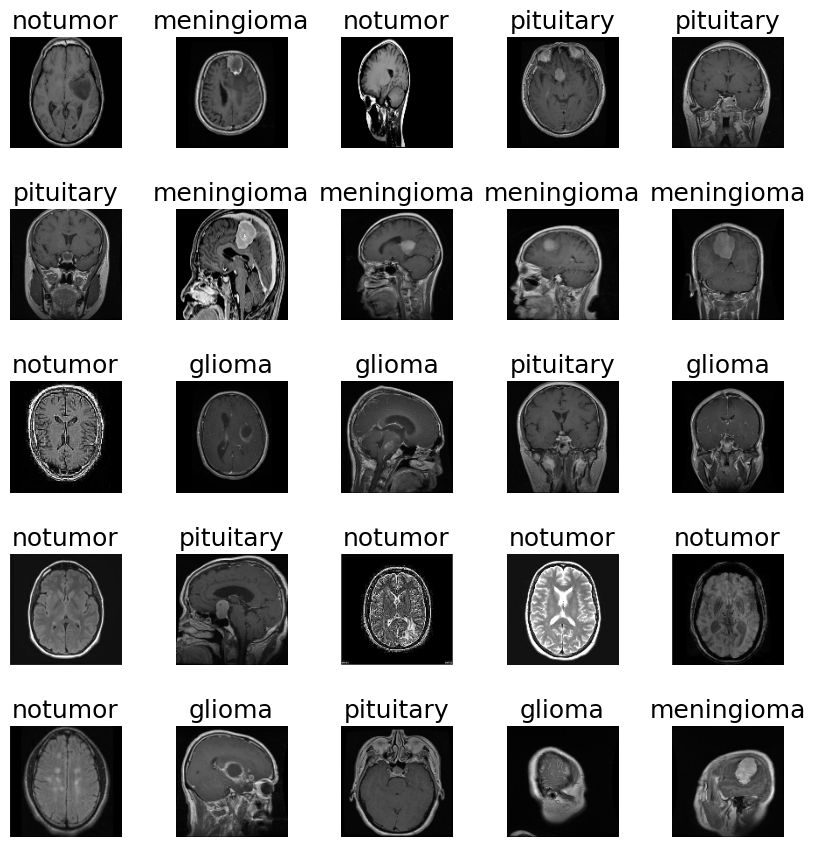

In [5]:
grid_width = 5
grid_height = 5
f, ax = plt.subplots(grid_width, grid_height)
f.set_size_inches(8, 8)

img_idx = 0
for i in range(0, grid_width):
    for j in range(0, grid_height):
        ax[i][j].axis('off') # remove the axis ticks and labels for the current subplot
        ax[i][j].set_title(Y_train[img_idx])
        ax[i][j].imshow(X_train[img_idx])
        img_idx += 1

# adjust the spacing between the subplots to make them look nicer
plt.subplots_adjust(left=0, bottom=0, right=1, top=1, wspace=0.2, hspace=0.55)  

Let's check the distribution of different classes in the dataset.

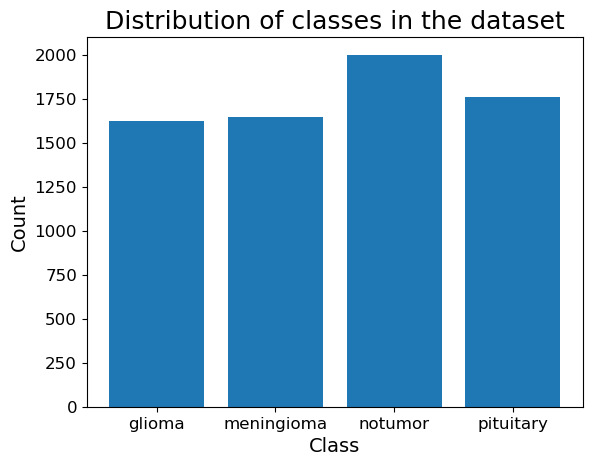

In [6]:
classes, counts = np.unique(Y_train, return_counts=True)

plt.bar(classes, counts)
plt.xlabel('Class')
plt.ylabel('Count')
plt.title('Distribution of classes in the dataset')
plt.show()

We can see that the training set is well-balanced, so we don't need to worry about imbalance issues. 

## Data Preprocessing


In [7]:
# Split the data: train (70%), valid (10%) and test (20%)
X_train, X_test, Y_train, Y_test = train_test_split(X_train, Y_train, test_size=0.2, random_state=42)
X_train, X_valid, Y_train, Y_valid = train_test_split(X_train, Y_train, test_size=0.1, random_state=42)

In [8]:
y_train_new = []
y_valid_new = []
y_test_new = []

# converting String Label to integer i.e
# glioma ---> 0, meningioma---> 1, notumor ---> 2, pituitary ---> 3
for i in Y_train:
    y_train_new.append(labels.index(i))

# Converts a class vector (integers) to binary class matrix
Y_train = to_categorical(y_train_new) 

for i in Y_valid:
    y_valid_new.append(labels.index(i))

Y_valid = to_categorical(y_valid_new)

for i in Y_test:
    y_test_new.append(labels.index(i))

Y_test = to_categorical(y_test_new)

In [9]:
Y_train

array([[0., 0., 0., 1.],
       [0., 0., 0., 1.],
       [1., 0., 0., 0.],
       ...,
       [0., 0., 1., 0.],
       [0., 0., 0., 1.],
       [0., 0., 1., 0.]], dtype=float32)

Each image has 3 channels (red, green, and blue). The images will be **rescaled**, i.e., the pixels will be divided by 255. Also, note the **size of the images** in this dataset is different. We will set IMAGE_SIZE = 128 when we build the models.

In [10]:
# Scaling Train, Valid and Test Features
X_train_scaled = X_train.astype('float32')
X_valid_scaled = X_valid.astype('float32')
X_test_scaled = X_test.astype('float32')

X_train_scaled /= 255
X_valid_scaled /= 255
X_test_scaled /= 255

## Models, Results & Analysis
### CNN Model (basic)
A Convolutional Neural Network (CNN) is a type of deep learning algorithm that is particularly well-suited for image recognition. **CNNs consist of multiple layers: convolutional layers, pooling layers, and fully connected layers.** In the convolutional layers, filters are applied to images to extract important features, which are then passed through multiple layers to classify the image. 
The input for a CNN model are tensors of shape (image_height, image_width, color_channels), where color_channels are R, G, and B.

Let's first build a very basic CNN model (model_cnn1):

In [11]:
# set the size of the input images to 128x128 pixels
IMAGE_SIZE = 128

# initializes a sequential model
model_cnn1 = Sequential()

# adds a convolutional layer with 8 filters, a kernel size of 3x3, and ReLU activation function
# the input shape of the layer is (128, 128, 3); 3 represents the number of color channels 
model_cnn1.add(Conv2D(8, kernel_size=(3,3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
# adds a max pooling layer with a pool size of 2x2, which reduces the spatial dimensions of the output feature maps by half
model_cnn1.add(MaxPooling2D(pool_size=(2,2)))

# adds another convolutional layer with 16 filters and a kernel size of 3x3
model_cnn1.add(Conv2D(16, kernel_size=(3,3), activation='relu'))
# adds another max pooling layer with a pool size of 2x2
model_cnn1.add(MaxPooling2D(pool_size=(2,2)))

# flattens the output feature maps into a 1D vector
model_cnn1.add(Flatten())
# adds a fully connected layer with 4 output units and a softmax activation function
# outputs a probability distribution over the 4 classes
model_cnn1.add(Dense(4, activation='softmax'))

# compiles the model with the Adam optimizer, categorical cross-entropy loss function, and accuracy metric
# 'adm' optimizer helps to speed up the convergence by adjusting the step size of each parameter update based on the magnitude of the gradients
model_cnn1.compile(optimizer='adam', loss='CategoricalCrossentropy', metrics=['accuracy'])

# prints a summary of the model architecture
model_cnn1.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 126, 126, 8)       224       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 63, 63, 8)        0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 61, 61, 16)        1168      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 30, 30, 16)       0         
 2D)                                                             
                                                                 
 flatten (Flatten)           (None, 14400)             0         
                                                                 
 dense (Dense)               (None, 4)                 5

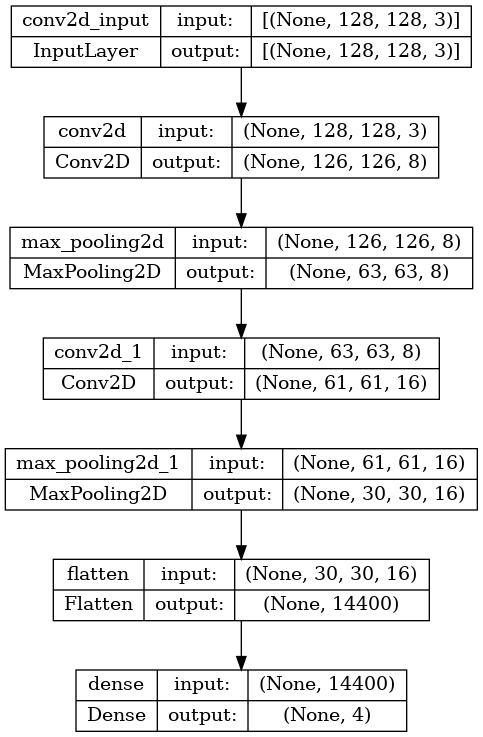

In [12]:
keras.utils.plot_model(model_cnn1, show_shapes=True)

### Train the basic CNN model (model_cnn1)

In [13]:
history1 = model_cnn1.fit(x=X_train_scaled, y=Y_train,
                   validation_data=(X_valid_scaled, Y_valid),
                   batch_size=32,
                   epochs=10,
                   verbose=1)

Epoch 1/10
158/158 [==============================] - 21s 132ms/step - loss: 0.7211 - accuracy: 0.7126 - val_loss: 0.5146 - val_accuracy: 0.8114
Epoch 2/10
158/158 [==============================] - 21s 131ms/step - loss: 0.4048 - accuracy: 0.8463 - val_loss: 0.4187 - val_accuracy: 0.8559
Epoch 3/10
158/158 [==============================] - 21s 131ms/step - loss: 0.2903 - accuracy: 0.8966 - val_loss: 0.3995 - val_accuracy: 0.8559
Epoch 4/10
158/158 [==============================] - 20s 127ms/step - loss: 0.2116 - accuracy: 0.9225 - val_loss: 0.3009 - val_accuracy: 0.8915
Epoch 5/10
158/158 [==============================] - 21s 130ms/step - loss: 0.1531 - accuracy: 0.9458 - val_loss: 0.3146 - val_accuracy: 0.9021
Epoch 6/10
158/158 [==============================] - 20s 129ms/step - loss: 0.1080 - accuracy: 0.9648 - val_loss: 0.2747 - val_accuracy: 0.9128
Epoch 7/10
158/158 [==============================] - 20s 129ms/step - loss: 0.0747 - accuracy: 0.9771 - val_loss: 0.2865 - val_ac

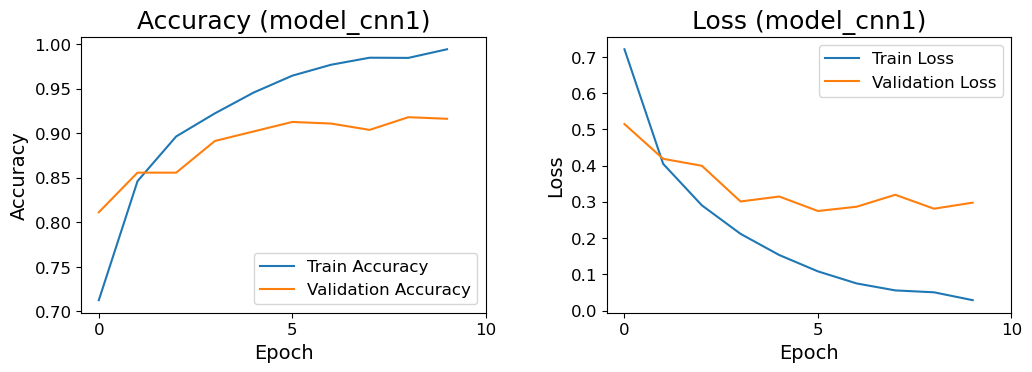

In [14]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
f.subplots_adjust(top=0.8, wspace=0.3)

epoch_list = list(range(1,11))
ax1.plot(history1.history['accuracy'], label='Train Accuracy')
ax1.plot(history1.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 11, 5))
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy (model_cnn1)')
l1 = ax1.legend(loc="best")

ax2.plot(history1.history['loss'], label='Train Loss')
ax2.plot(history1.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 11, 5))
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss (model_cnn1)')
l2 = ax2.legend(loc="best")

The first model is very simple with just two convolutional layers, a max pooling layer, a flattened layer, and a dense layer with softmax activation. It performed pretty well, given how simple it is! To improve its performance, we'll try some **hyperparameter tuning**. 

### Hyperparameter tuning 

- Increase the number of filters in the convolutional layers: this can help the model learn more complex features in the data.
- Add another convolutional layer: the first model has only two convolutional layers which may not be sufficient.
- Add a dropout layer as regulation: this may help reduce overfitting and improve generalization.
- Add another dense layer: this may increase the model's capacity to learn more complex patterns in the data.

In [15]:
model_cnn2 = Sequential()
model_cnn2.add(Conv2D(16, kernel_size=(3,3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model_cnn2.add(MaxPooling2D(pool_size=(2,2)))

model_cnn2.add(Conv2D(32, kernel_size=(3,3), activation='relu'))
model_cnn2.add(MaxPooling2D(pool_size=(2,2)))

model_cnn2.add(Conv2D(128, kernel_size=(3,3), activation='relu'))
model_cnn2.add(MaxPooling2D(pool_size=(2,2)))

model_cnn2.add(Flatten())
model_cnn2.add(Dropout(0.5))
model_cnn2.add(Dense(512, activation='relu'))
model_cnn2.add(Dense(4, activation='softmax'))

model_cnn2.compile(optimizer='adam', loss='CategoricalCrossentropy', metrics=['accuracy'])
model_cnn2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 126, 126, 16)      448       
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 63, 63, 16)       0         
 2D)                                                             
                                                                 
 conv2d_3 (Conv2D)           (None, 61, 61, 32)        4640      
                                                                 
 max_pooling2d_3 (MaxPooling  (None, 30, 30, 32)       0         
 2D)                                                             
                                                                 
 conv2d_4 (Conv2D)           (None, 28, 28, 128)       36992     
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 14, 14, 128)     

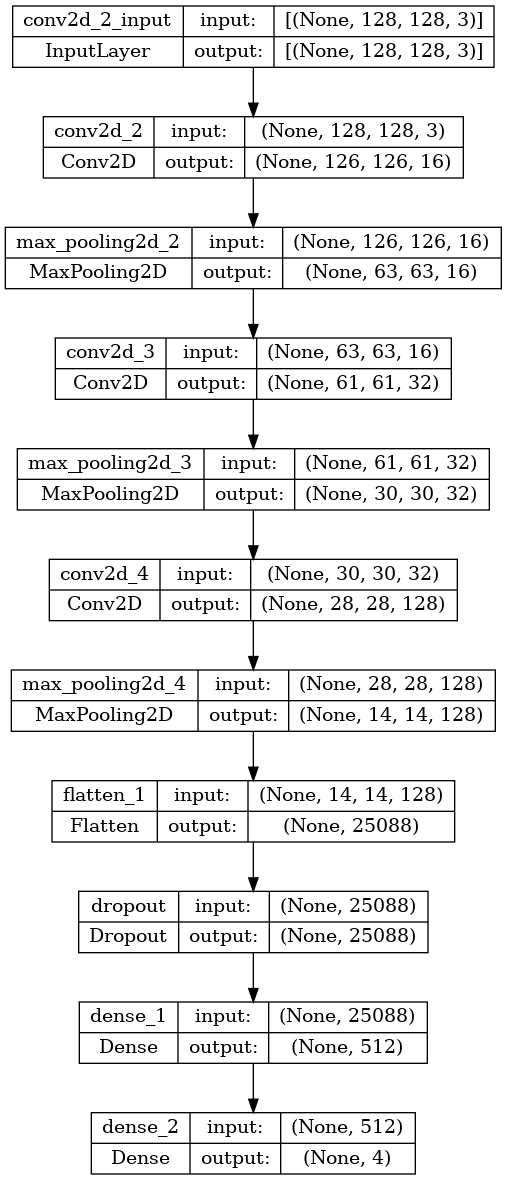

In [16]:
keras.utils.plot_model(model_cnn2, show_shapes=True)

### Train the second CNN Model (model_cnn2)

In [17]:
history2 = model_cnn2.fit(x=X_train_scaled, y=Y_train,
                   validation_data=(X_valid_scaled, Y_valid),
                   batch_size=32,
                   epochs=10,
                   verbose=1)

Epoch 1/10
158/158 [==============================] - 54s 340ms/step - loss: 0.7667 - accuracy: 0.6855 - val_loss: 0.4657 - val_accuracy: 0.8238
Epoch 2/10
158/158 [==============================] - 54s 340ms/step - loss: 0.3908 - accuracy: 0.8422 - val_loss: 0.5070 - val_accuracy: 0.7989
Epoch 3/10
158/158 [==============================] - 54s 339ms/step - loss: 0.2845 - accuracy: 0.8859 - val_loss: 0.3064 - val_accuracy: 0.8879
Epoch 4/10
158/158 [==============================] - 55s 347ms/step - loss: 0.2034 - accuracy: 0.9219 - val_loss: 0.4118 - val_accuracy: 0.8719
Epoch 5/10
158/158 [==============================] - 53s 335ms/step - loss: 0.1459 - accuracy: 0.9436 - val_loss: 0.2447 - val_accuracy: 0.9128
Epoch 6/10
158/158 [==============================] - 53s 334ms/step - loss: 0.1113 - accuracy: 0.9595 - val_loss: 0.3177 - val_accuracy: 0.9057
Epoch 7/10
158/158 [==============================] - 53s 336ms/step - loss: 0.0771 - accuracy: 0.9723 - val_loss: 0.2735 - val_ac

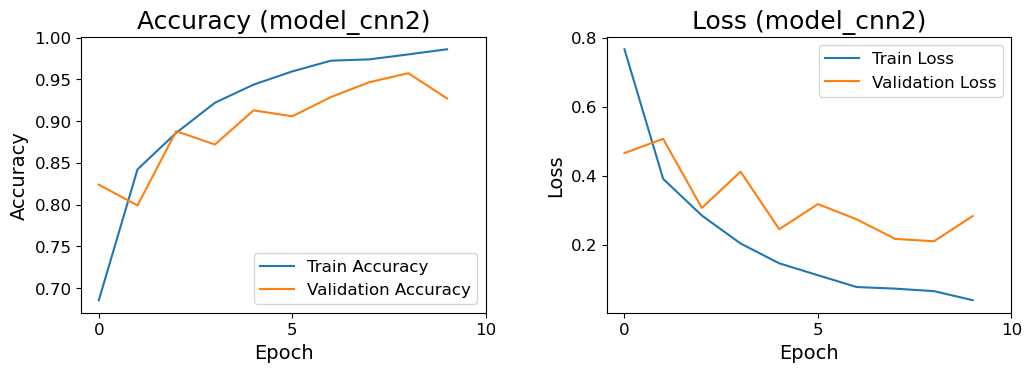

In [18]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
f.subplots_adjust(top=0.8, wspace=0.3)

epoch_list = list(range(1, 11))
ax1.plot(history2.history['accuracy'], label='Train Accuracy')
ax1.plot(history2.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 11, 5))
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy (model_cnn2)')
l1 = ax1.legend(loc="best")

ax2.plot(history2.history['loss'], label='Train Loss')
ax2.plot(history2.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 11, 5))
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss (model_cnn2)')
l2 = ax2.legend(loc="best")

As we can see, the second model performed better with a higher validation accuracy and lower validation loss. To further improve its performance, we'll do more hyperparameter tuning. 

### More hyperparameter tuning
- Increase the number of filters in each convolutional layer.
- Use a slightly higher dropout rate: this may further reduce overfitting.

In [19]:
model_cnn3 = Sequential()
model_cnn3.add(Conv2D(32, kernel_size=(3,3), activation='relu', input_shape=(IMAGE_SIZE, IMAGE_SIZE, 3)))
model_cnn3.add(MaxPooling2D(pool_size=(2,2)))

model_cnn3.add(Conv2D(64, kernel_size=(3,3), activation='relu'))
model_cnn3.add(MaxPooling2D(pool_size=(2,2)))

model_cnn3.add(Conv2D(256, kernel_size=(3,3), activation='relu'))
model_cnn3.add(MaxPooling2D(pool_size=(2,2)))

model_cnn3.add(Flatten())
model_cnn3.add(Dropout(0.6))
model_cnn3.add(Dense(512, activation='relu'))
model_cnn3.add(Dense(4, activation='softmax'))

model_cnn3.compile(optimizer='adam', loss='CategoricalCrossentropy', metrics=['accuracy'])
model_cnn3.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_5 (Conv2D)           (None, 126, 126, 32)      896       
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 63, 63, 32)       0         
 2D)                                                             
                                                                 
 conv2d_6 (Conv2D)           (None, 61, 61, 64)        18496     
                                                                 
 max_pooling2d_6 (MaxPooling  (None, 30, 30, 64)       0         
 2D)                                                             
                                                                 
 conv2d_7 (Conv2D)           (None, 28, 28, 256)       147712    
                                                                 
 max_pooling2d_7 (MaxPooling  (None, 14, 14, 256)     

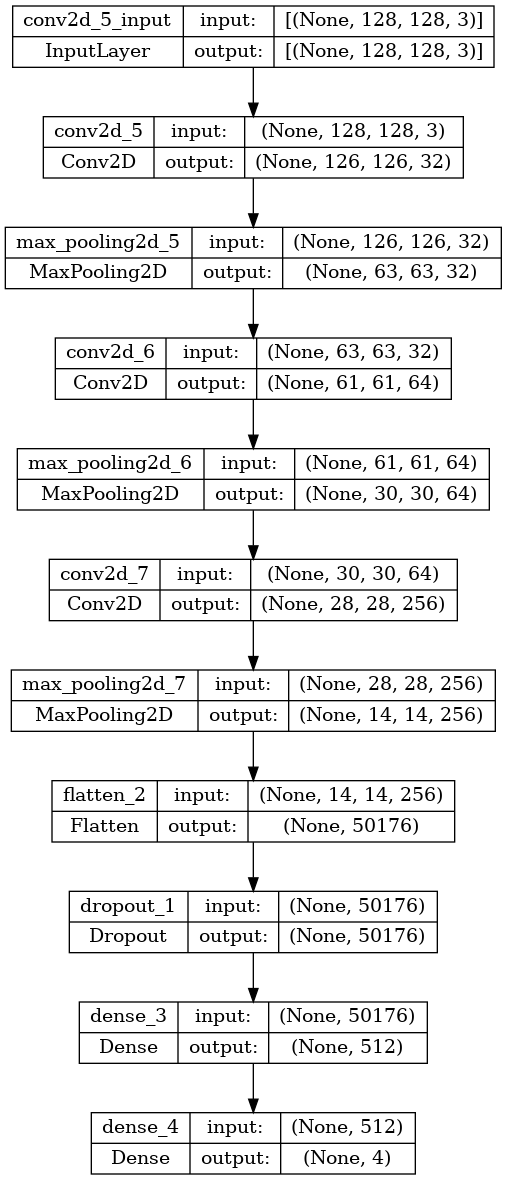

In [20]:
keras.utils.plot_model(model_cnn3, show_shapes=True)

### Train the third CNN Model (model_cnn3)

In [21]:
history3 = model_cnn3.fit(x=X_train_scaled, y=Y_train,
                   validation_data=(X_valid_scaled, Y_valid),
                   batch_size=32,
                   epochs=10,
                   verbose=1)

Epoch 1/10
158/158 [==============================] - 116s 733ms/step - loss: 0.7067 - accuracy: 0.7193 - val_loss: 0.4721 - val_accuracy: 0.8132
Epoch 2/10
158/158 [==============================] - 116s 731ms/step - loss: 0.3693 - accuracy: 0.8580 - val_loss: 0.3126 - val_accuracy: 0.9057
Epoch 3/10
158/158 [==============================] - 116s 734ms/step - loss: 0.2564 - accuracy: 0.9001 - val_loss: 0.2355 - val_accuracy: 0.9306
Epoch 4/10
158/158 [==============================] - 117s 739ms/step - loss: 0.1814 - accuracy: 0.9322 - val_loss: 0.2016 - val_accuracy: 0.9235
Epoch 5/10
158/158 [==============================] - 116s 735ms/step - loss: 0.1286 - accuracy: 0.9511 - val_loss: 0.1598 - val_accuracy: 0.9537
Epoch 6/10
158/158 [==============================] - 116s 733ms/step - loss: 0.0946 - accuracy: 0.9644 - val_loss: 0.1781 - val_accuracy: 0.9537
Epoch 7/10
158/158 [==============================] - 116s 731ms/step - loss: 0.0931 - accuracy: 0.9668 - val_loss: 0.1779 -

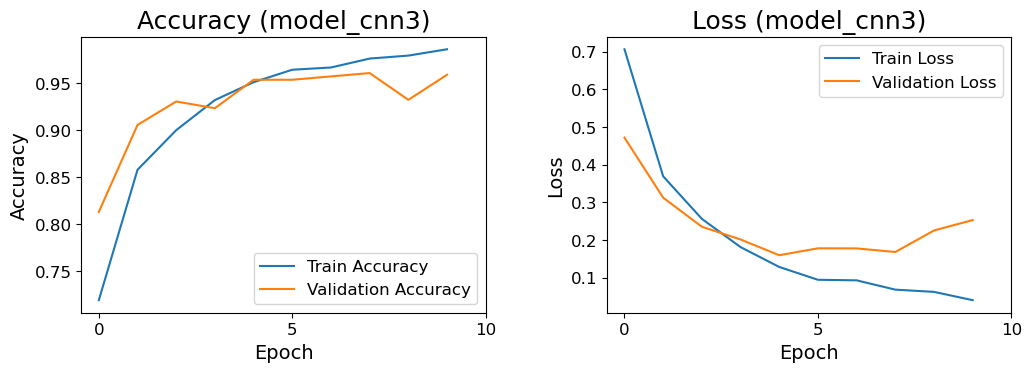

In [22]:
f, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))
f.subplots_adjust(top=0.8, wspace=0.3)

epoch_list = list(range(1, 11))
ax1.plot(history3.history['accuracy'], label='Train Accuracy')
ax1.plot(history3.history['val_accuracy'], label='Validation Accuracy')
ax1.set_xticks(np.arange(0, 11, 5))
ax1.set_ylabel('Accuracy')
ax1.set_xlabel('Epoch')
ax1.set_title('Accuracy (model_cnn3)')
l1 = ax1.legend(loc="best")

ax2.plot(history3.history['loss'], label='Train Loss')
ax2.plot(history3.history['val_loss'], label='Validation Loss')
ax2.set_xticks(np.arange(0, 11, 5))
ax2.set_ylabel('Loss')
ax2.set_xlabel('Epoch')
ax2.set_title('Loss (model_cnn3)')
l2 = ax2.legend(loc="best")

<center>
Comparisions of all the three models
</center>

|          | Train Accuracy |Validation Accuracy |Train Loss |Validation Loss |
|----------|----------|----------|----------|----------|
| model_cnn1 | 0.99 | 0.92 |0.04 | 0.30 |
| model_cnn2 | 0.99 | 0.93 |0.04 | 0.28 |
| model_cnn3 | 0.99 | 0.96 |0.04 | 0.25 |

### Evaluate Model with Test Samples

In [23]:
predictions = model_cnn3.predict(X_test_scaled)
# extracts the predicted class labels from the predictions array 
preds = np.argmax(predictions, axis=1)
# extracts the true class labels from the one-hot encoded Y_test array 
actual_label = np.argmax(Y_test, axis=1)

44/44 [==============================] - 8s 182ms/step


### Confusion Matrix

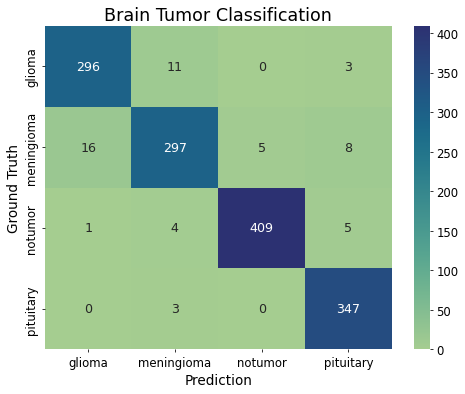

In [24]:
cm = confusion_matrix(actual_label, preds)
plt.figure(figsize=(8,6), dpi=70, facecolor='w', edgecolor='k')
ax = sns.heatmap(cm, cmap='crest', annot=True, fmt = 'd', xticklabels=labels, yticklabels=labels)
plt.title('Brain Tumor Classification')
plt.xlabel('Prediction')
plt.ylabel('Ground Truth')
plt.show(ax)

In [25]:
# prints a classification report that contains various metrics for evaluating the performance
print(classification_report(actual_label, preds))

              precision    recall  f1-score   support

           0       0.95      0.95      0.95       310
           1       0.94      0.91      0.93       326
           2       0.99      0.98      0.98       419
           3       0.96      0.99      0.97       350

    accuracy                           0.96      1405
   macro avg       0.96      0.96      0.96      1405
weighted avg       0.96      0.96      0.96      1405



### ROC Curves

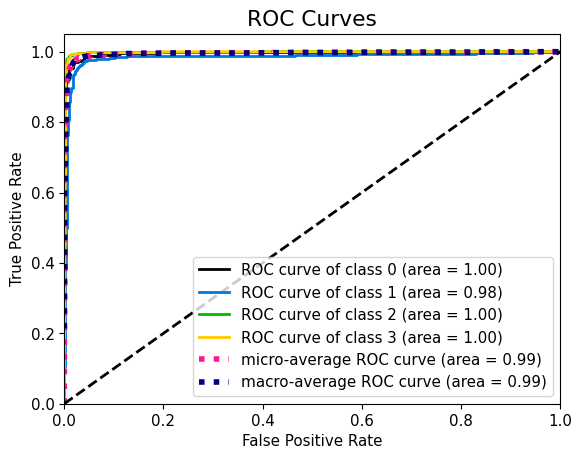

In [26]:
skplt.metrics.plot_roc(actual_label, predictions, text_fontsize='small')
plt.show()

## Discussion & Conclusion
- In this project, we used a convolutional neural network to detect and classify brain tumors based on brain imaging data. Deep Learning (DL) is a powerful tool and is likely to perform the task with higher accuracy than manual classification. 
- The first model performed well given how simple the model is. We were able to further improve its performance by hyperparameter tunning and achieved an accuracy of 96%. 
- To improve the stability and convergence, we also tried to add batch normalization layers after each convolutional layer. However, this was not helpful and impaired the model's performance. It is because the input data is already normalized so batch normalization may not provide any additional benefit and even hinder performance.
- To further improve the model, future work may focus on:
  - Try pre-trained models such as VGG
  - Use data augmentation to increase the size and diversity of the training set
  - Increase the training data

## Reference
- https://www.healthline.com/health/brain-tumor
- https://www.aans.org/Patients/Neurosurgical-Conditions-and-Treatments/Brain-Tumors
- https://www.hopkinsmedicine.org/health/conditions-and-diseases/brain-tumor/brain-tumor-types
- https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset?datasetId=1608934&sortBy=voteCount
- https://www.kaggle.com/code/mohamedeldakrory8/brain-tumor-mri-classification-graduation
- https://www.kaggle.com/code/ucrkmveri/brain-tumour-detection-using-vgg16